In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primaldual_PINN import *
from matplotlib.tri import Triangulation
import utility
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

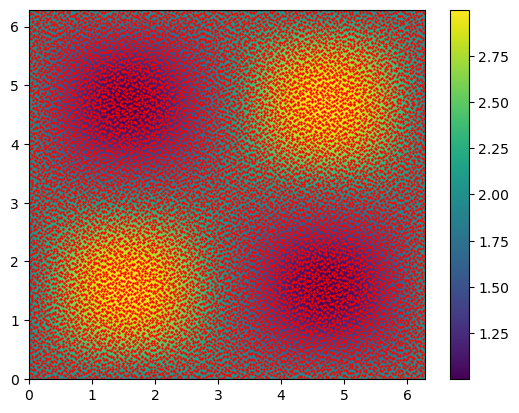

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = 2+np.sin(x)*np.sin(y)
    return a

def A(x):  
    a = (2+torch.sin(x[:,0])*torch.sin(x[:,1])).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = (2+torch.sin(x[:,0])*torch.sin(x[:,1])).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1/a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

In [5]:
net_H1 = PINN_2(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 30000, 'dev' : dev, 'name' : f'NN_library/PINN_double/sin/PINN_double_{total_params}'}

Number of parameters: 130


In [6]:
net_H1 = load_network(net_H1, args['name']+'_29999', args)
net_H1 = net_H1.to(dev)

In [10]:
losses_train, losses_val = train(net_H1, loaders, args, A, H1, L)

Epoch: 0 mean train loss:  6.44838512e-01, mean val. loss:  6.36995375e-01
Epoch: 1 mean train loss:  6.42166317e-01, mean val. loss:  6.34338617e-01
Epoch: 2 mean train loss:  6.39510095e-01, mean val. loss:  6.31698430e-01
Epoch: 3 mean train loss:  6.36870265e-01, mean val. loss:  6.29074633e-01
Epoch: 4 mean train loss:  6.34247184e-01, mean val. loss:  6.26467586e-01
Epoch: 5 mean train loss:  6.31640613e-01, mean val. loss:  6.23877704e-01
Epoch: 6 mean train loss:  6.29051149e-01, mean val. loss:  6.21304691e-01
Epoch: 7 mean train loss:  6.26478732e-01, mean val. loss:  6.18749022e-01
Epoch: 8 mean train loss:  6.23923600e-01, mean val. loss:  6.16210818e-01
Epoch: 9 mean train loss:  6.21385872e-01, mean val. loss:  6.13690138e-01
Epoch: 10 mean train loss:  6.18865728e-01, mean val. loss:  6.11187160e-01
Epoch: 11 mean train loss:  6.16363168e-01, mean val. loss:  6.08702123e-01
Epoch: 12 mean train loss:  6.13878667e-01, mean val. loss:  6.06235027e-01
Epoch: 13 mean train l

In [ ]:
np.save(f'NN_library/training_data/PINN_double_{total_params}', np.vstack([losses_train, losses_val]))

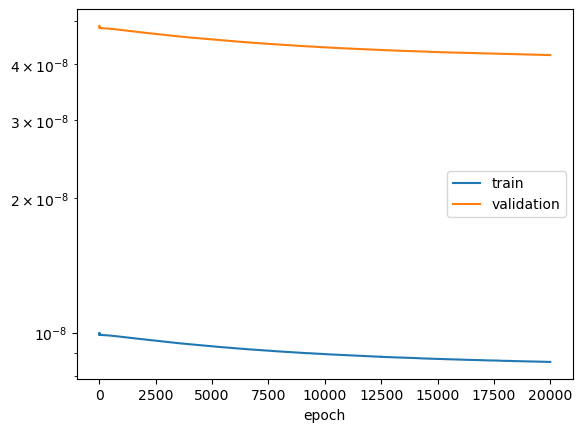

In [42]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [7]:
U1 = net_H1(grid_data)
pde_p, pde_d, _, _ = PDE_loss_primal_dual(grid_data, net_H1, A, H1)

C:\Users\gaynuliy\AppData\Local\Temp\ipykernel_29536\2234196343.py:12: RuntimeWarning: divide by zero encountered in log10
  pos6 = axs[1,2].pcolormesh(XY[0], XY[1], np.log10(pde_d.reshape(N, N).detach().cpu()), cmap='inferno')


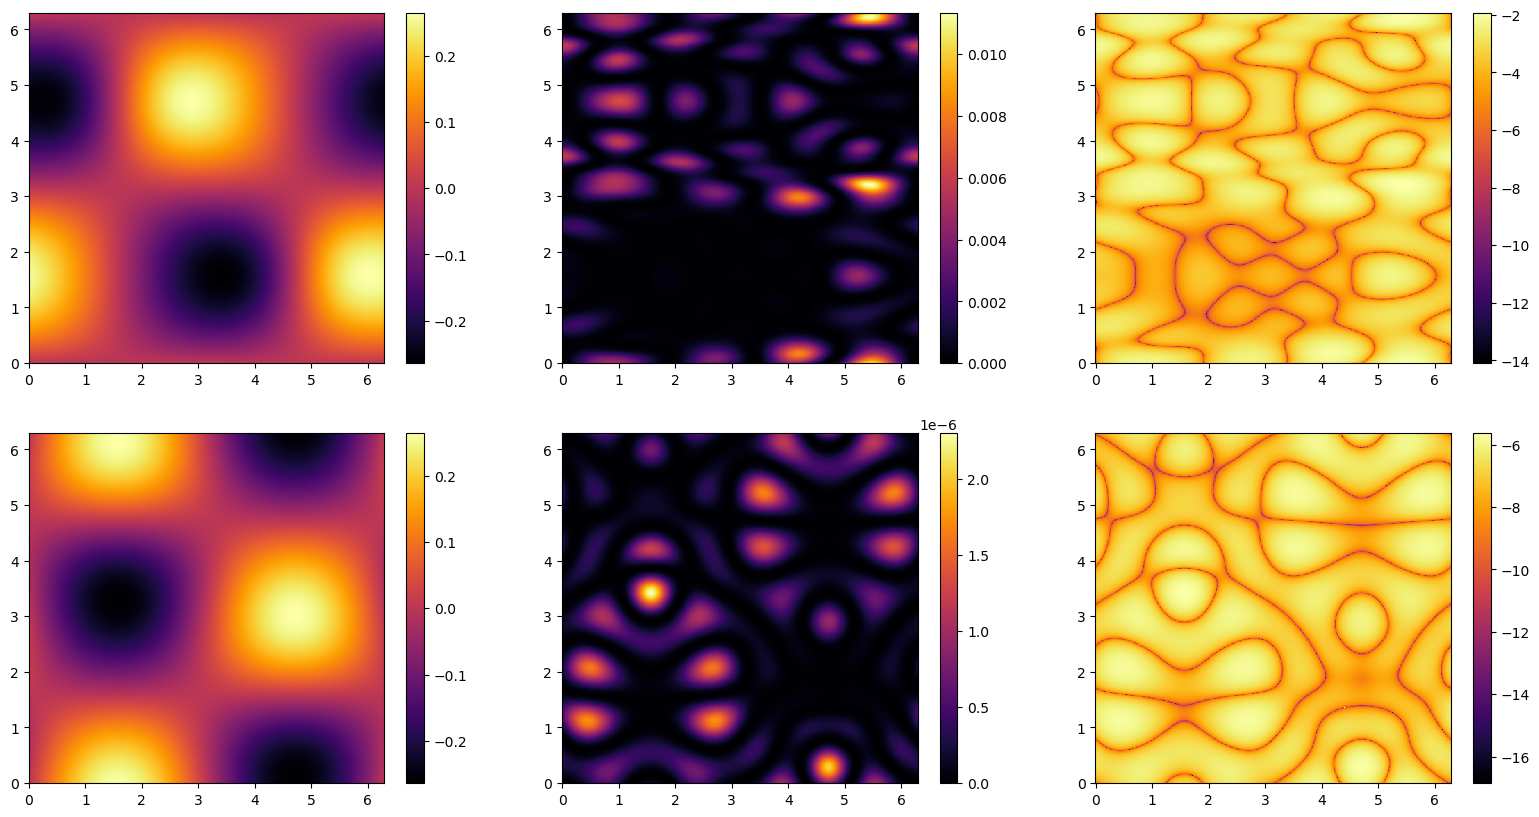

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19.5,10), dpi=100)
pos1 = axs[0,0].pcolormesh(XY[0], XY[1], U1[:,0].reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[1,0].pcolormesh(XY[0], XY[1], U1[:,1].reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos2, ax=axs[1,0])
pos3 = axs[0,1].pcolormesh(XY[0], XY[1], pde_p.reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos3, ax=axs[0,1])
pos4 = axs[1,1].pcolormesh(XY[0], XY[1], pde_d.reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos4, ax=axs[1,1])
pos5 = axs[0,2].pcolormesh(XY[0], XY[1], np.log10(pde_p.reshape(N, N).detach().cpu()), cmap='inferno')
fig.colorbar(pos5, ax=axs[0,2])
pos6 = axs[1,2].pcolormesh(XY[0], XY[1], np.log10(pde_d.reshape(N, N).detach().cpu()), cmap='inferno')
fig.colorbar(pos6, ax=axs[1,2])

In [9]:
inputs = data[:].to(dev).requires_grad_(True)
T1 = net_H1(inputs)[:,0]
dq1 = torch.autograd.grad(
            outputs=T1, inputs=inputs,
            grad_outputs=torch.ones_like(T1)
    )[0].detach()
triang = Triangulation(data[:,0], data[:,1])

In [14]:
T2 = net_H1(inputs)[:,1]
dq2 = torch.autograd.grad(
            outputs=T2, inputs=inputs,
            grad_outputs=torch.ones_like(T2)
    )[0].detach()
curl = torch.zeros_like(dq2)
curl[:,0] = -dq2[:,1]
curl[:,1] = dq2[:,0]

In [11]:
A_bound = utility.compute_bound(T1, dq1, triang, inputs, A, H1, L)
print(A_bound[0])
print(A_bound[1])

[[1.93562202e+00]
 [2.11780566e-05]]
[[ 1.98226372e+00]
 [-1.05166185e-03]]


In [15]:
B_bound = utility.compute_bound(T2, curl, triang, inputs, A_inv, H1, L, 'dual')

In [ ]:
print(B_bound[0])
print(B_bound[1])

[[ 1.93537237e+00 -2.07185073e-05]
 [-2.07185073e-05  1.93537237e+00]]
[[ 1.8955032  -0.00440973]
 [-0.00440973  1.8955032 ]]


In [17]:
np.save(f'bounds/sin/A_u_NN_double_{total_params}.npy', A_bound)
np.save(f'bounds/sin/A_l_NN_double_{total_params}.npy', B_bound)